<a href="https://colab.research.google.com/github/EvgSkv/virtual_people_examples/blob/main/notebooks/Particle_Ensemble_Adaptive_Dirac_Mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Particle Ensemble Adaptive Dirac Mixture
[EvgSkv](https://github.com/evgskv), Google

November 2023

In this CoLab we provide function to fit ADM to particular publisher x device marginals.

We use a novel Particle Ensemble ADM method for the fitting. This method finds a dirac mixture as a collection of equally-weighted dirac deltas i.e. particles. Fixing the weights of the dirac deltas makes the search space easier to explore with gradient descent methods.

We leverage JAX library and power of GPUs to find a good fit to the required constraints.

We test the function on synthetic data of 10 publishers and 2 devices. A mixture of 50 deltas functions fits the data within 2% margin of error for all publisher-device combinations.

Let us go over an example to demonstrate how we pressure test the method.

We create a list of 10 publishers, over 2 devices with custom device overlaps.

| Publisher | Desktop reach | Mobile reach | Reached through  mobile AND desktop |
|---|---|---|---|
| A | 0.2 | 0.3 | 0.1 |
| B | 0.1 | 0.1 | 0.05 |
| C | 0.15 | 0.1 | 0.05 |
| D | 0.1 | 0.1 | 0.01 |
| E | 0.25 | 0.25 | 0.24 |
| F | 0.1 | 0.25 | 0.1 |
| G | 0.2 | 0.1 | 0.05 |
| H | 0.3 | 0.2 | 0.2 |
| I | 0.3 | 0.2 | 0.01 |
| J | 0.3 | 0.5 | 0.2 |

We then create 31 sets of training points, i.e. $(\vec{c}, p)$ pairs, where $\vec{c}$ is a 20 dimensional per-publisher$\times$device cookies and $p$ is the number of people reached.

* One set are points are spread across publisher/device proportionally. It is assumed to follow [exponential box](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/1ab33ed15e0a7724c7b0b47361da16259fee8eef.pdf), i.e. $p = \frac{\kappa c p}{\kappa c + p}$, we set $\kappa = 0.9$.

* We also create a set of points for each of the 10 publishers, each device and cross device, 30 in total. We assume Exponential Bow within each publisher and device

Recall that Dirac Mixture reach function is $$p = \sum_{i=1}^n \alpha_i \left(1 - \exp \left(-\vec{c} \cdot \vec{d_i}\right)\right)$$

In this colab we set $n = 50$ and $\alpha_i = \frac{1}{50}$. Initially $\vec{d}_i$ are sampled uniformly at random from $\{ x | x \in \mathbb{R}, 0 \leq x \leq 3\}^{20}$, i.e. the 20-dimensional cube with the side $[0, 3]$. Optimization is performed using [ADAM method](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) with [JAX library](https://github.com/google/jax).




We observe high fit fidelity for all the points, meaning that optimizer is able
to find the allocation of activity to deltas, which reflects the desired intra-pub device overlaps, as well as the overall curve.

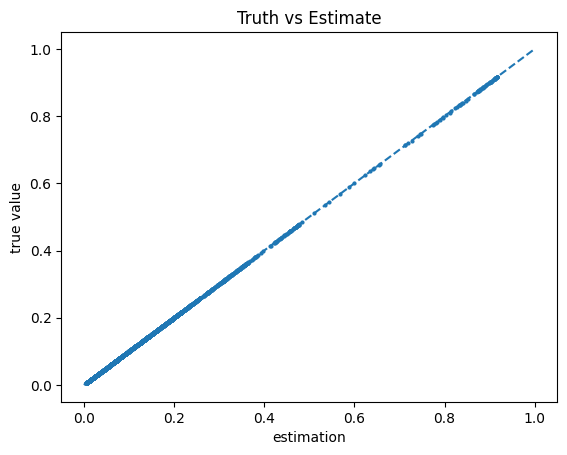


In [ ]:
!git clone -b ti2023 https://github.com/evgskv/logica

Cloning into 'logica'...
remote: Enumerating objects: 3936, done.
remote: Counting objects: 100% (1381/1381), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 3936 (delta 1175), reused 1267 (delta 1141), pack-reused 2555
Receiving objects: 100% (3936/3936), 4.15 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (2508/2508), done.


'done'

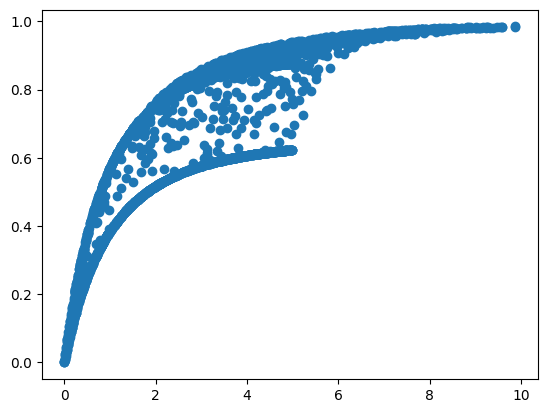

In [ ]:
from scipy import optimize
from jax import numpy
import numpy as numpy_classic
from matplotlib import pyplot


class DiracMixture(object):
  def __init__(self, alphas, ds):
    self.alphas = alphas
    self.ds = ds
    self.params = {'ds': ds, 'alphas': alphas}

  def __call__(self, signal):
    return numpy.hstack(self.alphas).dot((1 - numpy.exp(- self.ds.dot(signal.T))))

# Creating a toy mixture of 2 deltas.
toy_signal = numpy_classic.random.uniform(0, 5, (1000, 2))
toy_signal = numpy.vstack([toy_signal,
                           toy_signal * numpy.array([[0, 1]]),
                           toy_signal * numpy.array([[1, 0]])])

toy_ds = numpy.array([[1.5, 1.5],
                      [0.5, 1.5],
                      [1.0, 1.0],
                      [0.5, 0.6],
                      [0.75, 0.5],
                      [1.0, 0.5],
                      [1.25, 0.5],
                      [1.5, 0.6],
                      [0.4, 0],
                      [0, 1.3],
                      [3.5, 3.5]])
toy_alphas = numpy.concatenate([numpy.zeros(8) + 1./16. , numpy.array([0.1, 0.35]), numpy.array([0.05])])
toy_dm = DiracMixture(toy_alphas, numpy.array(toy_ds))

toy_target = toy_dm(toy_signal)

pyplot.scatter(toy_signal.sum(axis=1), toy_target)

'done'

rm: cannot remove '*png': No such file or directory


loss=0.06517: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.58it/s]


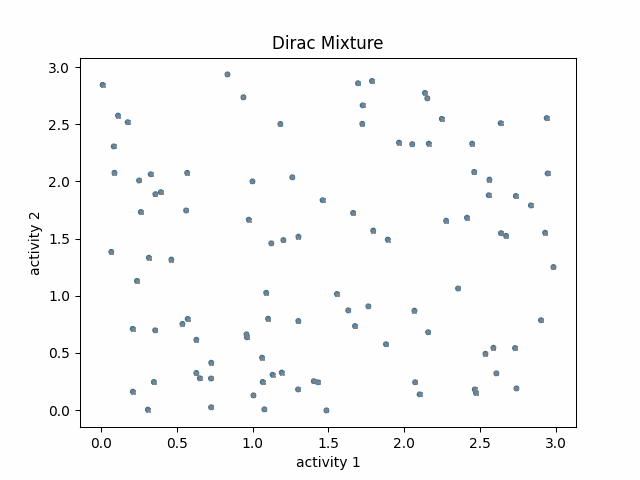

loss=0.13578: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.29it/s]


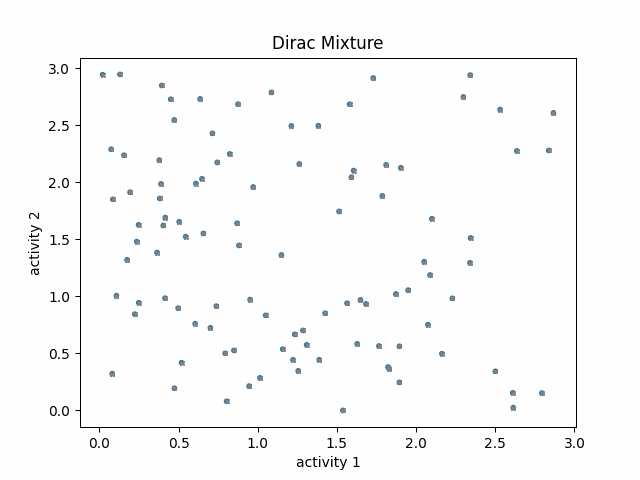

In [ ]:
from matplotlib import pyplot
from jax import grad
import jax
import tqdm
import optax
from logica.common import image
from IPython import display

def FitEnsambleADM(signal, target,
                   num_centers, num_iter,
                   animate=False,
                   animation_step=10,
                   fit_alphas=True,
                   learning_rate=0.01,
                   init_params=None):
  dim = signal.shape[1]

  # Equal weights.
  init_alphas = numpy.zeros(num_centers) + 1.0 / num_centers
  # Random initial activities.
  init_ds = numpy_classic.random.uniform(
      0.0, 3.0, size=num_centers * dim).reshape((num_centers, dim)) + 0.0

  params = init_params or {'alphas': init_alphas.copy(),
                           'ds': init_ds}
  adam = optax.adam(learning_rate=learning_rate)
  opt_state = adam.init(params)

  @jax.jit
  def net(x, params):
    if not fit_alphas:
      alphas = init_alphas
    else:
      alphas = numpy.maximum(0, params['alphas'])
    ds = numpy.maximum(0, params['ds'])
    dm = DiracMixture(alphas, ds)
    return dm(x)

  @jax.jit
  def loss(params, x):
    error = (target - net(x, params)) ** 2
    weighted_error = error / (0.00000000001 + target) ** 2
    actual_loss = numpy.sum(weighted_error)
    alpha_positivity_incentive = numpy.sum(numpy.minimum(0.0, params['alphas']))
    activity_positivity_incentive = numpy.sum(numpy.minimum(0.0, params['ds']))
    return actual_loss - alpha_positivity_incentive - activity_positivity_incentive

  value_and_grad = jax.value_and_grad(loss)
  bar = tqdm.tqdm(range(num_iter), ncols=150)
  global FRAME_NUM
  for i in bar:
    loss_value, loss_grads = value_and_grad(params, signal)
    updates, opt_state = adam.update(loss_grads, opt_state)
    mask = (params['alphas'] < 0).reshape((len(params['ds']), 1))
    params['ds'] = params['ds'] + mask * (init_ds - params['ds'])
    params = optax.apply_updates(params, updates)
    bar.set_description('loss=%.5f' % (loss_value))
    if animate and i % animation_step == 0:
      pyplot.figure()
      pyplot.title('Dirac Mixture')
      pyplot.xlabel('activity 1')
      pyplot.ylabel('activity 2')
      pyplot.scatter(params['ds'][:, 0], params['ds'][:, 1],
                     s=numpy.maximum(0, params['alphas'] * 1000))
      pyplot.scatter(params['ds'][:, 0], params['ds'][:, 1],
                     marker='x', color='gray', s=10)

      pyplot.savefig('ds_%05d.png' % FRAME_NUM)
      pyplot.close()
    FRAME_NUM = FRAME_NUM + 1


  if animate:
    image.AnimateFiles('ds_*.png', 'animation.gif', duration=50)

  return DiracMixture(params['alphas'], params['ds'])

!rm *png
FRAME_NUM = 0
# Fitting ADM with equal weights.
adm_1 = FitADM(toy_signal, toy_target, num_centers=100, num_iter=1000,
               animate=True, animation_step=100, fit_alphas=False,
               learning_rate=0.01)
# Displaying the process.
display.display(display.Image('animation.gif'))

!rm *png
FRAME_NUM = 0
# Fitting ADM with dynamic weights.
adm_2 = FitADM(toy_signal, toy_target, num_centers=100, num_iter=1000,
               animate=True, animation_step=100, fit_alphas=True,
               learning_rate=0.001)
# Displaying the process.
display.display(display.Image('animation.gif'))



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

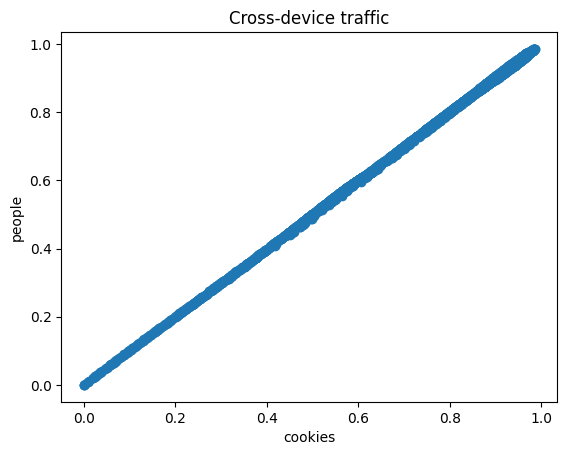

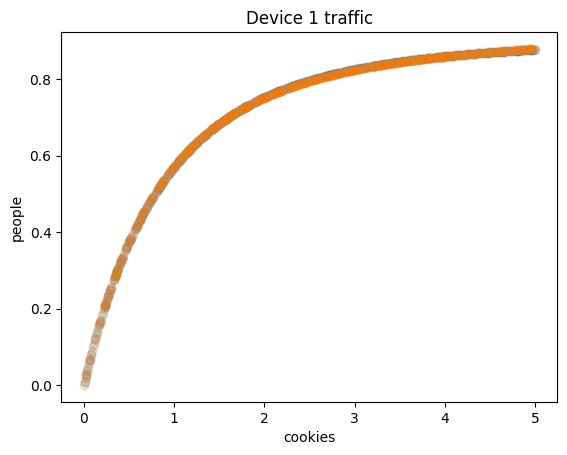

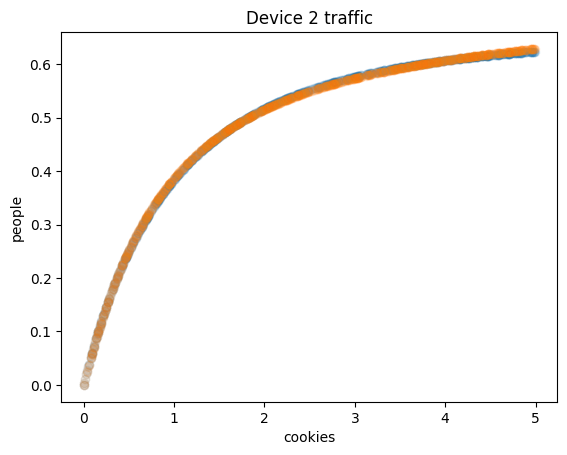

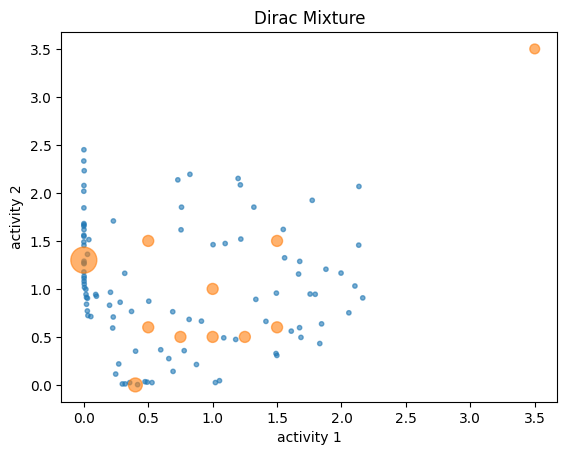

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

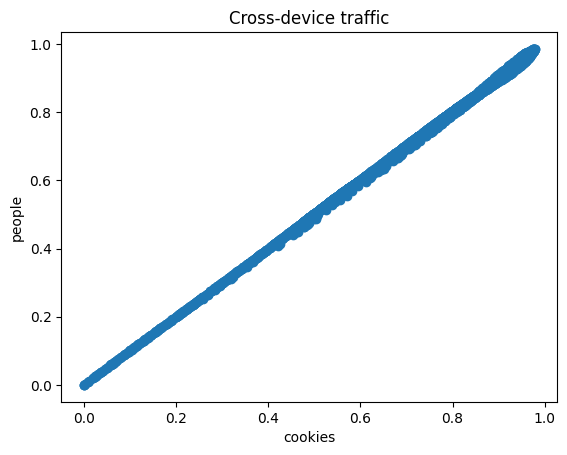

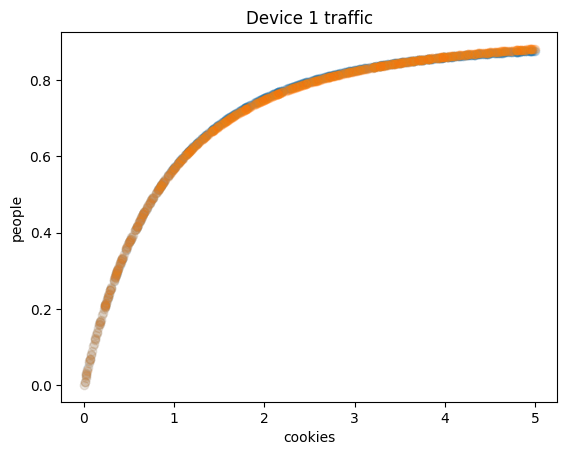

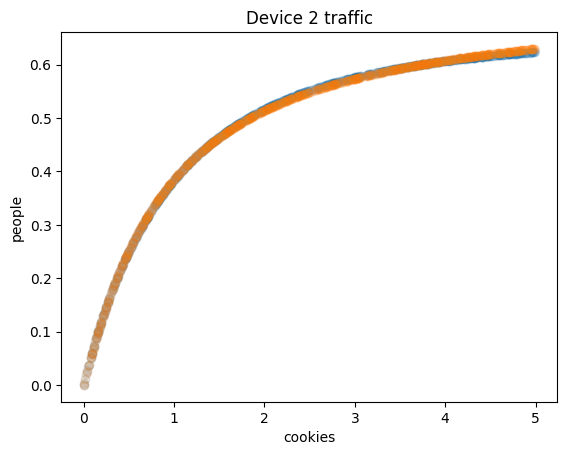

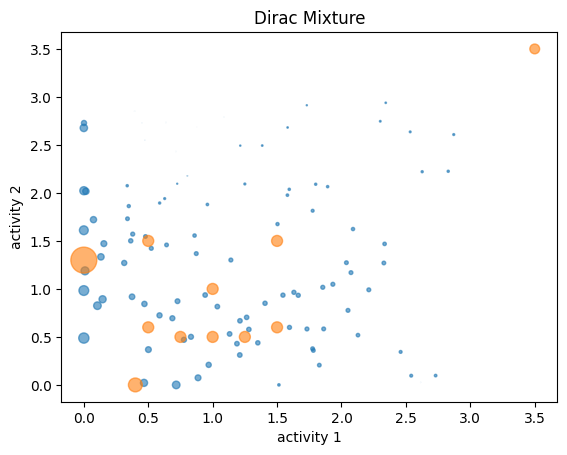

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets

bar = widgets.TabBar(['Equal alphas', 'Fitted alphas'])

for idx, dm in [(0, adm_1), (1, adm_2)]:
  with bar.output_to(idx):
    pyplot.figure()
    pyplot.scatter(dm(toy_signal), toy_target)
    pyplot.xlabel('cookies')
    pyplot.ylabel('people')
    pyplot.title('Cross-device traffic')

    pyplot.figure()
    pyplot.scatter(toy_signal[1000:2000, :].sum(axis=1), toy_target[1000:2000], alpha=0.1)
    pyplot.scatter(toy_signal[1000:2000, :].sum(axis=1), dm(toy_signal[1000:2000, :]), alpha=0.1)
    pyplot.xlabel('cookies')
    pyplot.ylabel('people')
    pyplot.title('Device 1 traffic')


    pyplot.figure()
    pyplot.scatter(toy_signal[2000:3000, :].sum(axis=1), toy_target[2000:3000], alpha=0.1)
    pyplot.scatter(toy_signal[2000:3000, :].sum(axis=1), dm(toy_signal[2000:3000, :]), alpha=0.1)
    pyplot.xlabel('cookies')
    pyplot.ylabel('people')
    pyplot.title('Device 2 traffic')

    pyplot.figure()
    pyplot.scatter(dm.ds[:, 0], dm.ds[:, 1], s=numpy.abs(dm.alphas*1000), alpha=0.6)
    pyplot.scatter(toy_ds[:, 0], toy_ds[:, 1], s=numpy.abs(toy_alphas*1000), alpha=0.6)
    pyplot.xlabel('activity 1')
    pyplot.ylabel('activity 2')
    pyplot.title('Dirac Mixture')

    pyplot.show()


Let's fit to some complex data now.

First we create the data, assuming that traffic is coming from a few publishers and two devices. For each publiser x device combination we determine the total population available. Then we generate cross-publisher-device curve and per publisher-device curve for each publisher and device.

In [ ]:
numpy_classic.set_printoptions(linewidth=200)


#              Desktiop, Mobile, Overlap
pub_info = [[  0.2,      0.3,    0.1    ],
            [  0.1,      0.1,    0.05   ],
            [  0.15,     0.1,    0.05   ],
            [  0.1,      0.1,    0.01    ],
            [  0.25,     0.25,   0.24    ],
            [  0.1,      0.25,   0.1    ],
            [  0.2,      0.1,    0.05   ],
            [  0.3,      0.2,    0.2    ],
            [  0.3,      0.2,    0.01    ],
            [  0.3,      0.5,    0.2    ]]

# #              Desktiop, Mobile, Overlap
# pub_info = [[  0.2,      0.3,    0.1    ]]


num_devices = 2
kappa = 0.9

pi = numpy.array(pub_info)
num_pubs, _ = pi.shape


pub_population = pi.sum(axis=1) - pi[:, 3] * 2
# print(pub_population)

cookie_distribution = pi[:, :2].reshape((1, num_pubs * num_devices))
# print('cookie distribution: \n', cookie_distribution)
cookie_counts = numpy_classic.random.uniform(0, 3, size=100).reshape(
    (-1, 1))

cv = cookie_counts * cookie_distribution

def LogBow(c, p):
  return kappa * c * p / (kappa * c + p)

# Adding cross-publisher-cross-device traffic.
signal_chunks = [cv]
target_chunks = [LogBow(cv.sum(axis=1), 1)]


pub_idx, device_idx = numpy.indices(pi.shape)

for i in range(num_pubs):
  indices = numpy.indices((num_pubs * num_devices,))
  mask = (indices == 2 * i) * 1 + (indices == 2 * i + 1) * 1
  c = cv * mask

  # Single publisher.
  p1 = LogBow(cv[:, 2 * i], pi[i, 0])
  p2 = LogBow(cv[:, 2 * i + 1], pi[i, 1])
  p10 = p1  / pi[i, 0]
  p20 = p2  / pi[i, 1]
  p = p1 + p2 - pi[i, 2] * (p10 * p20)

  signal_chunks.append(c)
  target_chunks.append(p)

  # Single publisher, first device.
  mask = (indices == 2 * i) * 1
  c = cv * mask
  p = LogBow(c.sum(axis=1), pi[i, 0])
  signal_chunks.append(c)
  target_chunks.append(p)

  # Single publisher, second device.
  mask = (indices == 2 * i + 1) * 1
  c = cv * mask
  p = LogBow(c.sum(axis=1), pi[i, 1])
  signal_chunks.append(c)
  target_chunks.append(p)


signal = numpy.vstack(signal_chunks)
target = numpy.concatenate(target_chunks)

# Uncomment to print when debugging.
# print(numpy_classic.hstack([signal, target.reshape((-1, 1))]))



'done'

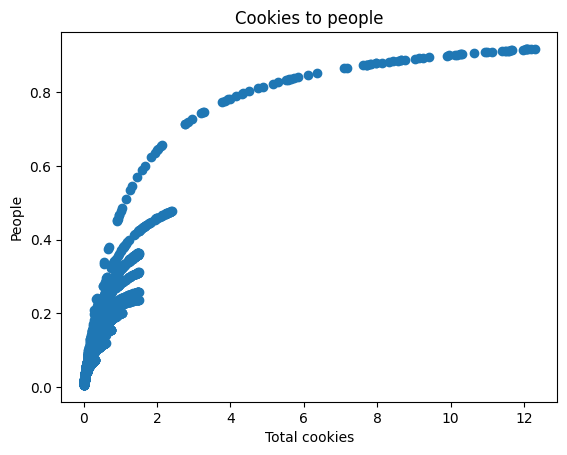

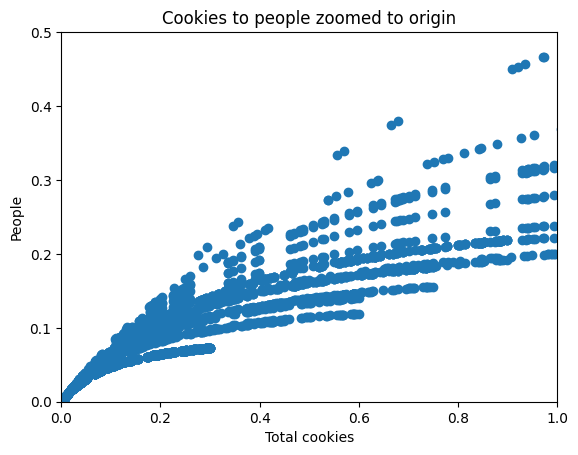

In [ ]:
# Plotting the data in 2D as simply total cookie count vs total people.
# Plotting cross-device and marginals on one chart.

pyplot.figure()
pyplot.scatter(signal.sum(axis=1), target)
pyplot.xlabel('Total cookies')
pyplot.ylabel('People')
pyplot.title('Cookies to people')

pyplot.figure()
pyplot.scatter(signal.sum(axis=1), target)
pyplot.xlim(0, 1)
pyplot.ylim(0, 0.5)
pyplot.xlabel('Total cookies')
pyplot.ylabel('People')
pyplot.title('Cookies to people zoomed to origin')

'done'

loss=0.01383: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:28<00:00, 56.40it/s]


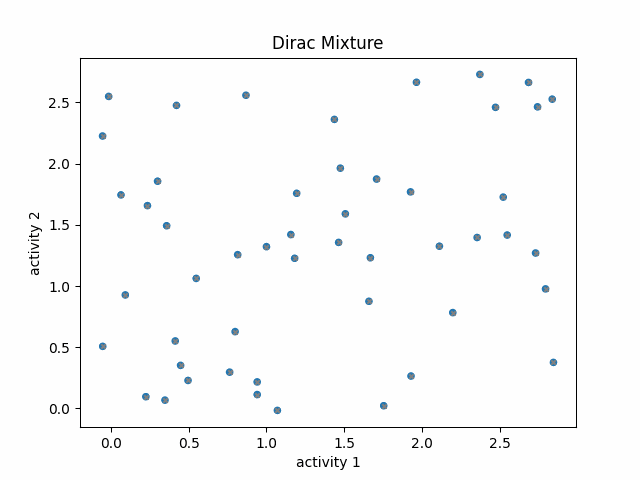

In [ ]:
# Fitting ADM to the data.
# Using multiple stages for optimization efficiency.

!rm *png
FRAME_NUM = 0

num_centers = 50
fit_alphas = False

# Here is how to run one epoch optimization.
# adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=10000,
#              animate=True, animation_step=100, fit_alphas=fit_alphas,
#              learning_rate=0.01)

# Here is how to run a multi-epoc optimization.
adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=1000,
                     animate=True, animation_step=100, fit_alphas=fit_alphas,
                     learning_rate=0.1)
adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=2000,
                     animate=True, animation_step=100, fit_alphas=fit_alphas,
                     learning_rate=0.01, init_params=adm.params)
adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=2000,
                     animate=True, animation_step=100, fit_alphas=fit_alphas,
                     learning_rate=0.001, init_params=adm.params)
adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=5000,
                     animate=True, animation_step=100, fit_alphas=fit_alphas,
                     learning_rate=0.0005, init_params=adm.params)
adm = FitEnsambleADM(signal, target, num_centers=num_centers, num_iter=5000,
                     animate=True, animation_step=100, fit_alphas=fit_alphas,
                     learning_rate=0.0001, init_params=adm.params)

display.display(display.Image('animation.gif'))

Kappas: [0.89847976 0.90002316 0.88090366 0.8857035  0.8962458  0.88537115 0.8844512  0.88807297 0.89924634 0.89875865 0.89165974 0.8993022  0.89907736 0.8828784  0.89893043 0.8989549  0.898896   0.8988889
 0.89845306 0.8993921 ]
Populaiton: 0.9999996


'done'

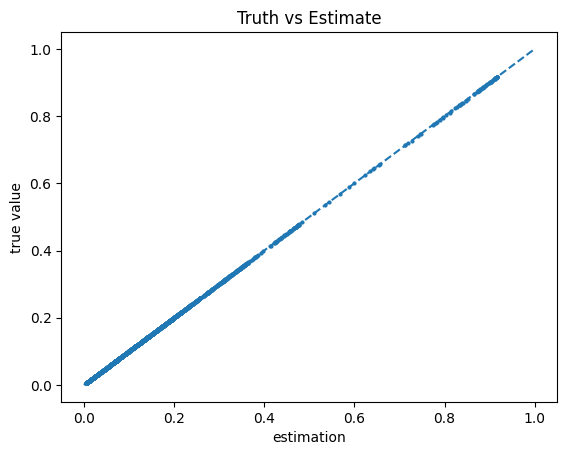

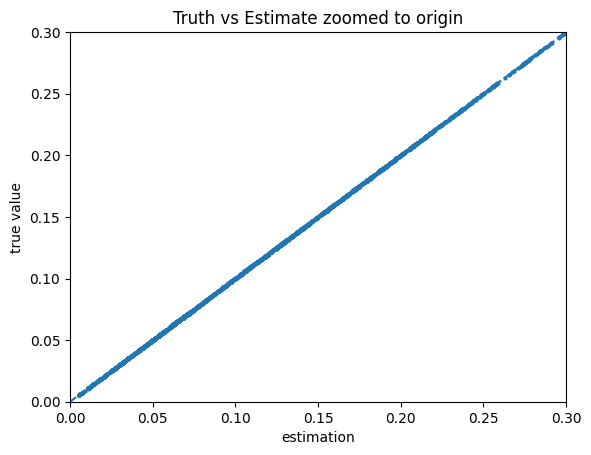

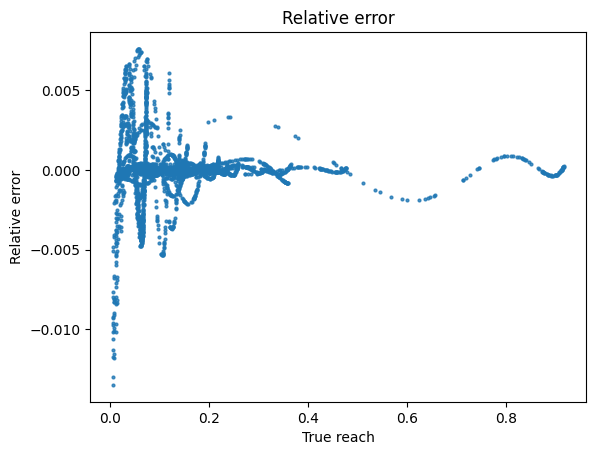

In [ ]:
# Plotting truth vs estimation and error plot.

print('Kappas:', (adm.ds * adm.alphas.reshape((-1, 1))).sum(axis=0))
print('Populaiton:', sum(adm.alphas))
pyplot.figure()
pyplot.scatter(adm(signal), target, s=4)
pyplot.plot([0,1], [0,1], linestyle='--')
pyplot.xlabel('estimation')
pyplot.ylabel('true value')
pyplot.title('Truth vs Estimate')

pyplot.figure()
pyplot.scatter(adm(signal), target, s=4)
pyplot.plot([0,1], [0,1], linestyle='--')
pyplot.xlim((0, 0.3))
pyplot.ylim((0, 0.3))
pyplot.xlabel('estimation')
pyplot.ylabel('true value')
pyplot.title('Truth vs Estimate zoomed to origin')

pyplot.figure()
pyplot.title('Relative error')
pyplot.scatter(target, adm(signal) / target - 1.0, alpha=0.8, s=4)
pyplot.xlabel('True reach')
pyplot.ylabel('Relative error')

'done'

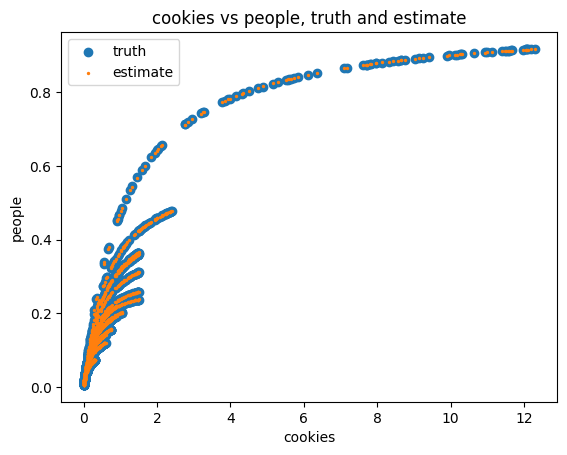

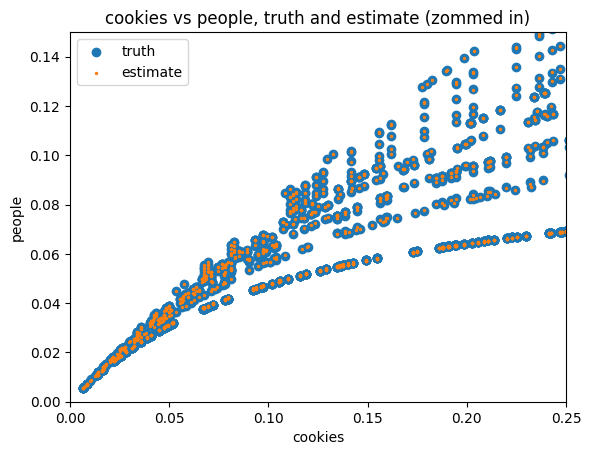

'done'

In [ ]:
pyplot.figure()
pyplot.title('cookies vs people, truth and estimate')
pyplot.xlabel('cookies')
pyplot.ylabel('people')
pyplot.scatter(signal.sum(axis=1), target, label='truth')
pyplot.scatter(signal.sum(axis=1), adm(signal), label='estimate', s=2)
pyplot.legend(loc='best')
pyplot.show()


pyplot.figure()
pyplot.title('cookies vs people, truth and estimate (zommed in)')
pyplot.xlabel('cookies')
pyplot.ylabel('people')
pyplot.scatter(signal.sum(axis=1), target, label='truth')
pyplot.scatter(signal.sum(axis=1), adm(signal), label='estimate', s=2)
pyplot.xlim(0, 0.25)
pyplot.ylim(0, 0.15)


pyplot.legend(loc='best')
pyplot.show()


'done'

'done'

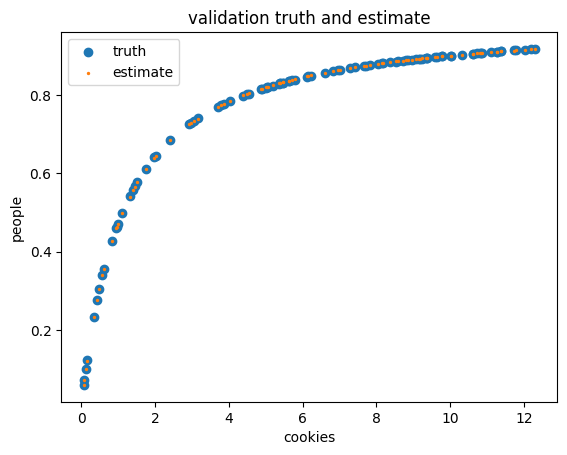

In [ ]:
# Let's create some new data random and check the ADM on it.

import numpy as numpy_classic
cookie_counts2 = numpy_classic.random.uniform(0, 3, size=100).reshape(
    (-1, 1))

cv2 = cookie_counts2 * cookie_distribution

pyplot.title('validation truth and estimate')
pyplot.scatter(cv2.sum(axis=1), LogBow(cv2.sum(axis=1), 1), label='truth')
pyplot.scatter(cv2.sum(axis=1), adm(cv2), s=2, label='estimate')
pyplot.xlabel('cookies')
pyplot.ylabel('people')
pyplot.legend(loc='best')

'done'